In [12]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import pandas as pd

from kiwipiepy import Kiwi

from collections import Counter

import time

In [13]:
kiwi = Kiwi()

def count_word(text, word_counts):
    # kiwi.analyze()로 분석 후, 품사가 'NNG'(일반 명사), 'NNP'(고유 명사)인 경우만 추출
    nouns = [token.form for token in kiwi.analyze(text)[0][0] if token.tag.startswith('NN')]
    new_word_counts = Counter(nouns) + word_counts
    return new_word_counts

In [14]:
driver = webdriver.Chrome(service=Service("../../driver/chromedriver"))

# url에 포함되어 있는 parameters
# 정렬 : sort={"0":관련도순, "1":최신순, "2":오래된순}
# 기간 : (시작기간)ds=YYYY.MM.DD, (끝기간)de=YYYY.MM.DD
# 유형 : photo={"0":전체, "1":포토, "2":동영상, "3":지면기사, ...}
# mynews=1, office_type=3, office_category=3으로 수정
company_name = "코스피"" ""마감"  # 검색어
date = "2016.06.24"      # 검색기간(하루로 제한 -> 추후 수정 예정)
url = f"https://search.naver.com/search.naver?ssc=tab.news.all&query={company_name}&sm=tab_opt&sort=0&photo=3&field=0&pd=3&ds={date}&de={date}&docid=&related=0&mynews=1&office_type=3&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom{date.replace(".","")}to{date.replace(".","")}&is_sug_officeid=0&office_category=3&service_area=0"
driver.get(url)
time.sleep(2)            # 사이트 차단 방지를 위한 멈춤

In [15]:
# 기간 내 기사들의 링크 모두 가져오기

# 모든 기사가 보일때까지 스크롤
len_before_scroll = 0
while (True):
    # 현재 로드된 뉴스 기사 목록을 모두 가져온다 (CSS 선택자는 실제 페이지에 맞게 수정)
    articles = driver.find_elements(By.CSS_SELECTOR, "div.BHQHyn3Flk5rFBSacJkG")

    # 스크롤 후 기사 수
    len_after_scroll = len(articles)

    if len(articles) > 100:
        break

    # 목록의 끝에서 두 번째 항목을 타겟으로 지정 (마지막 항목은 푸터와 겹칠 수 있음)
    if len(articles) > 1:
        target_element = articles[-2]
        
        # JavaScript를 실행하여 해당 요소가 보이도록 스크롤
        driver.execute_script("arguments[0].scrollIntoView()", target_element)

        time.sleep(1)

    # 스크롤 전후 기사 수 비교 (같다면 더이상 스크롤 할 필요 X)
    if len_before_scroll == len_after_scroll:
        break

    len_before_scroll = len_after_scroll

In [16]:
# 네이버 뉴스 주소 가져오기

news_urls = []
news_info = driver.find_elements(By.CLASS_NAME, "sds-comps-horizontal-layout.sds-comps-full-layout.sds-comps-profile.type-basic.size-lg.title-color-g10.hRlTUxpL38wmDKxyAhSU")
for info in news_info:
    news_link = info.find_element(By.CLASS_NAME, "GUWgsNcVrWa67MoYor6N.xR1x3GgF_MIcYPUZNqEu")
    news_urls.append(news_link.get_attribute("href"))

In [20]:
driver.quit()

In [17]:
def get_news_content(url):
    req = Request(url, headers={'User-Agent': generate_user_agent()})
    page = urlopen(req)
    return BeautifulSoup(page, "html.parser")

In [18]:

word_counts=Counter()
for url in news_urls:
    soup = get_news_content(url)
    time.sleep(1)
    news_title = soup.find("div", class_="media_end_head_title").find("h2")
    news_date = soup.find("span", class_="media_end_head_info_datestamp_time _ARTICLE_DATE_TIME")['data-date-time']
    # print(news_date.split(" ")[0])
    news_content = soup.find("article", class_="go_trans _article_content")

    word_counts = count_word(news_content.text, word_counts)

print(word_counts)

Counter({'브렉시트': 137, '것': 106, '시장': 102, '원': 97, '영국': 83, '일': 77, '코스피': 69, '지수': 62, '년': 61, '하락': 53, '증시': 50, '달러': 49, '탈퇴': 48, '이날': 47, '등': 45, '자산': 45, '영향': 42, '이후': 41, '월': 41, '주': 41, '포인트': 35, '투자자': 35, '자금': 34, '투표': 33, '유럽': 33, '만': 32, '금융': 32, '급락': 32, '마감': 32, '말': 32, '기자': 32, '국내': 31, '수': 31, '주식': 31, '미국': 30, '우려': 29, '선': 29, '기록': 29, '장중': 28, '펀드': 28, '글로벌': 27, '가격': 27, '대비': 26, '하루': 26, '거래': 26, '유럽연합': 25, '투자': 25, '예상': 24, '상황': 24, '충격': 23, '상승': 23, '금리': 23, '전망': 22, '최대': 22, '장': 22, '안전': 22, '코스닥': 22, '시': 22, '경제': 21, '가능': 21, '변동': 21, '잔류': 21, '물': 21, '한국': 20, '매수': 20, '국민': 20, '개표': 20, '외국인': 19, '위험': 19, '전일': 19, '세계': 18, '결과': 18, '추가': 18, '선물': 18, '가치': 18, '레버리지': 18, '무단': 17, '전재': 17, '배포': 17, '금지': 17, '낙폭': 17, '다음': 17, '환율': 17, '오전': 17, '분': 17, '외환': 16, '단기': 16, '증권': 16, '전날': 16, '옵션': 16, '현실': 15, '경기': 15, '주가': 15, '최고': 15, '폭': 14, '금': 14, '시작': 14, '이번': 13, '정치': 13, '엔'

In [19]:
forbidden_words = ["등", "것", "년", "월", "일", "이날", "다음", "증시", "주식", "주가",
                    "주", "배포", "장", "마감", "하락", "때", "시", "수", "중", "코스피",
                    "코스닥", "지수", "시장", "경제", "종목", "머니투데이", "기자", "최대",
                    "최소", "오전", "오후", "뉴스", "물", "위", "차지", "증권", "씨", "원"]

for word in list(word_counts.keys()):
    if word in forbidden_words:
        del word_counts[word]

In [14]:
word_counts

Counter({'브렉시트': 137,
         '영국': 83,
         '달러': 49,
         '탈퇴': 48,
         '자산': 45,
         '영향': 42,
         '이후': 41,
         '포인트': 35,
         '투자자': 35,
         '자금': 34,
         '투표': 33,
         '유럽': 33,
         '만': 32,
         '금융': 32,
         '급락': 32,
         '말': 32,
         '국내': 31,
         '미국': 30,
         '우려': 29,
         '선': 29,
         '기록': 29,
         '장중': 28,
         '펀드': 28,
         '글로벌': 27,
         '가격': 27,
         '대비': 26,
         '하루': 26,
         '거래': 26,
         '유럽연합': 25,
         '투자': 25,
         '예상': 24,
         '상황': 24,
         '충격': 23,
         '상승': 23,
         '금리': 23,
         '전망': 22,
         '안전': 22,
         '가능': 21,
         '변동': 21,
         '잔류': 21,
         '한국': 20,
         '매수': 20,
         '국민': 20,
         '개표': 20,
         '외국인': 19,
         '위험': 19,
         '전일': 19,
         '세계': 18,
         '결과': 18,
         '추가': 18,
         '선물': 18,
         '가치': 18,
      

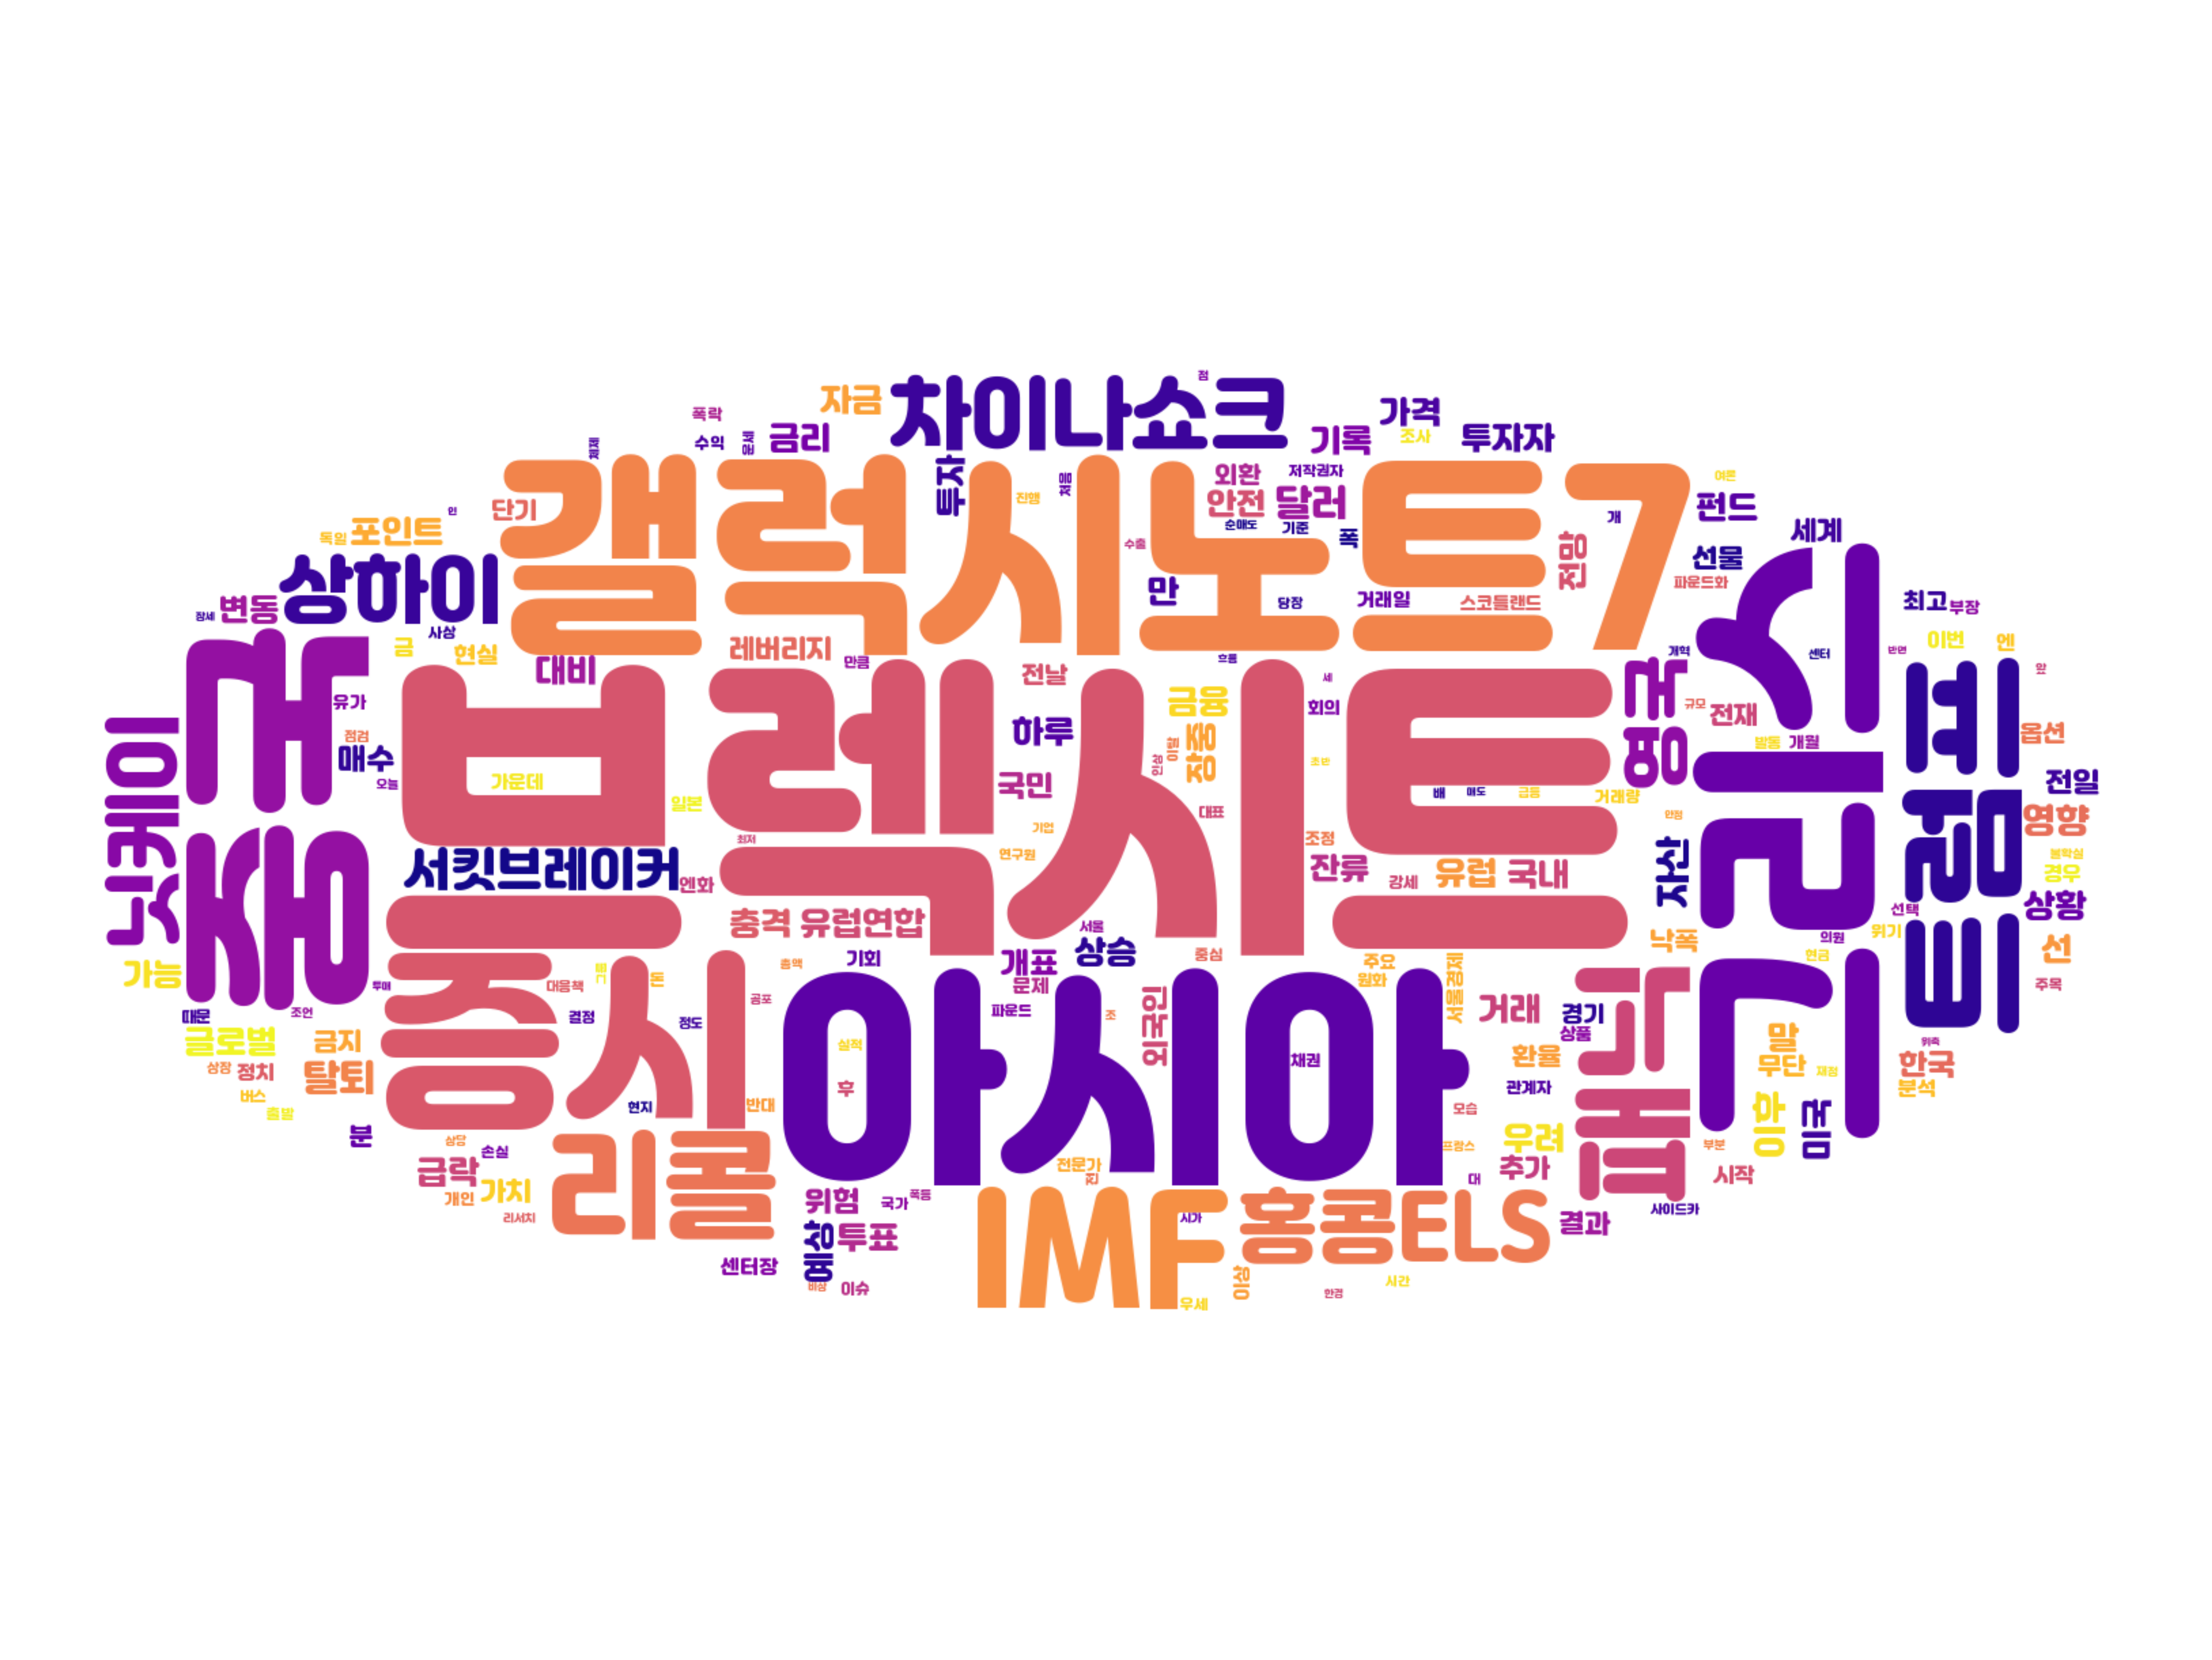

In [11]:
from wordcloud import WordCloud
import platform
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

font_path = '/home/taemin/dev_ws/EDA/src/project/Jalnan2TTF.ttf'

highlight_words = {
    '브렉시트' : 150,
    '아시아': 100,
    '증시': 80,
    '패닉': 60,
    '그리스' : 90,
    '갤럭시노트7' : 100,
    '리콜' : 60,
    'IMF' : 80,
    '차이나쇼크' : 60,
    '중국' : 80,
    '트럼프' : 70,
    '홍콩ELS' : 60,
    '상하이' : 50,
    '닛케이' : 55,
    '서킷브레이커' : 40,

}

# 기존 word_counts에 강조 단어 추가 또는 빈도수 덮어쓰기
word_counts.update(highlight_words)




wordcloud = WordCloud(
    mask = np.array(Image.open("/home/taemin/dev_ws/EDA/src/project/ellipse.png")),
    font_path=font_path,
    width=800,
    height=400,
    background_color='white',
    colormap="plasma" 
).generate_from_frequencies(word_counts)

plt.figure(figsize=(100, 100)) # 이미지 크기 설정
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # 축 숨기기
plt.show()
